In [1]:
"""
Animations for various dynamical systems using `matplotlib`.

Author: Spencer M. Richards
        Autonomous Systems Lab (ASL), Stanford
        (GitHub: spenrich)
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
import matplotlib.animation as animation


def animate_cartpole(t, x, θ):
    """Animate the cart-pole system from given position data.

    All arguments are assumed to be 1-D NumPy arrays, where `x` and `θ` are the
    degrees of freedom of the cart-pole over time `t`.

    Example usage:
        import matplotlib.pyplot as plt
        from animations import animate_cartpole
        fig, ani = animate_cartpole(t, x, θ)
        ani.save('cartpole.mp4', writer='ffmpeg')
        plt.show()
    """
    # Geometry
    cart_width = 2.
    cart_height = 1.
    wheel_radius = 0.3
    wheel_sep = 1.
    pole_length = 5.
    mass_radius = 0.25

    # Figure and axis
    fig, ax = plt.subplots(dpi=100)
    x_min, x_max = np.min(x) - 1.1*pole_length, np.max(x) + 1.1*pole_length
    y_min = -pole_length
    y_max = 1.1*(wheel_radius + cart_height + pole_length)
    ax.plot([x_min, x_max], [0., 0.], '-', linewidth=1, color='k')[0]
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_yticks([])
    ax.set_aspect(1.)

    # Artists
    cart = mpatches.FancyBboxPatch((0., 0.), cart_width, cart_height,
                                   facecolor='tab:blue', edgecolor='k',
                                   boxstyle='Round,pad=0.,rounding_size=0.05')
    wheel_left = mpatches.Circle((0., 0.), wheel_radius, color='k')
    wheel_right = mpatches.Circle((0., 0.), wheel_radius, color='k')
    mass = mpatches.Circle((0., 0.), mass_radius, color='k')
    pole = ax.plot([], [], '-', linewidth=3, color='k')[0]
    trace = ax.plot([], [], '--', linewidth=2, color='tab:orange')[0]
    timestamp = ax.text(0.1, 0.9, '', transform=ax.transAxes)

    ax.add_patch(cart)
    ax.add_patch(wheel_left)
    ax.add_patch(wheel_right)
    ax.add_patch(mass)

    def animate(k, t, x, θ):
        # Geometry
        cart_corner = np.array([x[k] - cart_width/2, wheel_radius])
        wheel_left_center = np.array([x[k] - wheel_sep/2, wheel_radius])
        wheel_right_center = np.array([x[k] + wheel_sep/2, wheel_radius])
        pole_start = np.array([x[k], wheel_radius + cart_height])
        pole_end = pole_start + pole_length*np.array([np.sin(θ[k]),
                                                      -np.cos(θ[k])])

        # Cart
        cart.set_x(cart_corner[0])
        cart.set_y(cart_corner[1])

        # Wheels
        wheel_left.set_center(wheel_left_center)
        wheel_right.set_center(wheel_right_center)

        # Pendulum
        pole.set_data([pole_start[0], pole_end[0]],
                      [pole_start[1], pole_end[1]])
        mass.set_center(pole_end)
        mass_x = x[:k+1] + pole_length*np.sin(θ[:k+1])
        mass_y = wheel_radius + cart_height - pole_length*np.cos(θ[:k+1])
        trace.set_data(mass_x, mass_y)

        # Time-stamp
        timestamp.set_text('t = {:.1f} s'.format(t[k]))

        artists = (cart, wheel_left, wheel_right, pole, mass, trace, timestamp)
        return artists

    dt = t[1] - t[0]
    ani = animation.FuncAnimation(fig, animate, t.size, fargs=(t, x, θ),
                                  interval=dt*1000, blit=True)
    return fig, ani



In [2]:
"""
Cartpole AA203 HW2 P4

Author: Pei-Chen Wu
"""

from scipy.integrate import odeint
#import sympy as sp
from scipy.stats import multivariate_normal

mp = 2
mc = 10
l = 1
g = 9.81

In [3]:
def cal_PK(Q_multiply = 1):    

    delta_t = 0.1
    Q = np.eye(4,4)*Q_multiply
    R = np.eye(1)

    df_ds_star = np.array([[0,0,1,0],
                       [0,0,0,1],
                       [0, mp*g/mc,0,0],
                       [0,(mc+mp)*g/(mc*l),0,0]])

    df_du_star = np.array([[0],
                       [0],
                       [1/mc],
                       [1/(mc*l)]])
    
    P = np.zeros((4,4)) # init
    
    A = (np.eye(4,4) + delta_t*df_ds_star)
    B = delta_t*df_du_star
    
    err = np.inf
    
    while err >= 1e-4:
        
        K = -np.linalg.inv(R+B.T@P@B)@B.T@P@A
        P_next = Q+A.T@P@(A+B@K)
        
        err = np.max(np.abs(P_next-P))
        
        P = P_next
    
    
    return K
        

In [4]:
def noise():
    return np.random.multivariate_normal([0.0, 0.0, 0.0, 0.0], np.diag([0,0,1e-3,1e-3]),1)

In [16]:
K = cal_PK(1)
K

array([[   0.7291397 , -231.85419273,    4.21967187,  -68.24742822]])

In [15]:
K = cal_PK(10)
K

array([[   2.26379564, -256.34294732,    8.42679164,  -76.04341843]])

In [19]:
#now make the time series
max_time = 100
freq = 10 #second subdivision (frequency/Hz)
dt = 1/freq #useful for the animation function
t = np.linspace(0,max_time+dt,int(freq*max_time)+1)

def cartpole(s,t,u):
    x = s[0]
    th = s[1]
    dx = s[2]
    dth = s[3]
    
    ddx = (mp*(l*dth*dth+g*np.cos(th))*np.sin(th)+u)/(mc+mp*np.sin(th)*np.sin(th))
    ddth = -1*((mc+mp)*g*np.sin(th)+mp*l*dth*dth*np.sin(th)*np.cos(th)+u*np.cos(th))/(l*(mc+mp*np.sin(th)*np.sin(th)))
    
    return np.array([dx, dth, ddx, ddth])

def simulate_sys(add_noise = False, part_e = False, Q_multiply = 1):
    
    K = cal_PK(Q_multiply)[0]
    
    if part_e:
        s_init = np.array([0,np.pi,0,0]) # s init
        #s_star = np.array([10*np.sin((2*np.pi/30)*0), np.pi, 10*(2*np.pi/30)*np.cos((2*np.pi/30)*0), 0])
    else:
        s_init = np.array([0,3*np.pi/4,0,0]) # s init
        s_star = np.array([0, np.pi, 0, 0])
    
    u = np.zeros(int(freq*max_time)+1)
    s_list = np.zeros((int(freq*max_time)+1,4))
    
    s_list[0,:] = s_init
    
    for i in range(len(t)-1):
        if part_e:
            s_star = np.array([10*np.sin(2*np.pi*t[i]/30), 
                               np.pi, 
                               10*(2*np.pi/30)*np.cos(2*np.pi*t[i]/30), 
                               0])
        
        u[i] = K.dot(s_list[i,:] - s_star)
        s_list[i+1,:] = odeint(cartpole, s_list[i,:], t[i:i+2], (u[i],))[1]
        
        if add_noise:
            s_list[i+1,:] += noise()[0] # add noise to the system
    
    return s_list

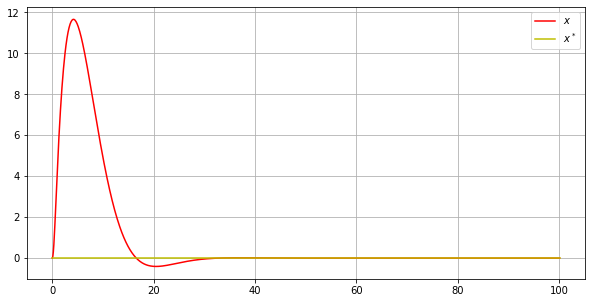

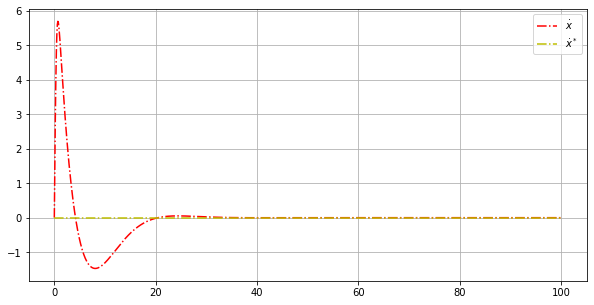

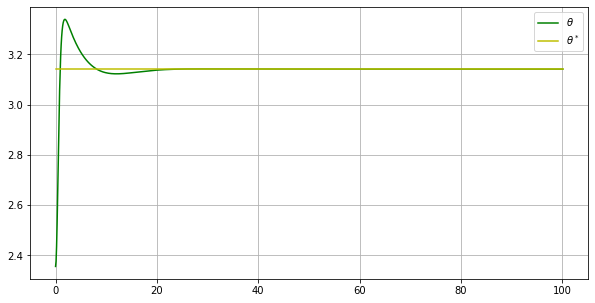

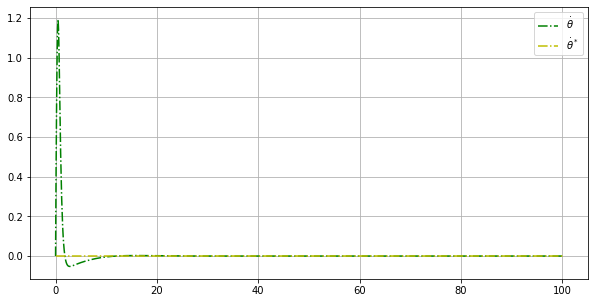

In [20]:
s_t = simulate_sys(add_noise = False, part_e = False, Q_multiply=1)

#Now plot the pos vs time
plt.figure(figsize=(10, 5))
plt.grid() #this allows us to see the grid
plt.plot(t,s_t[:,0],'r',label='$x$') 
plt.plot(t, np.zeros(t.shape), 'y', label='$x^*$')
plt.legend(fontsize=10) #show the legend

plt.show() #this says display the info here


#Now plot the pos vs time
plt.figure(figsize=(10, 5))
plt.grid() #this allows us to see the grid
plt.plot(t,s_t[:,2],'-.r',label='$\\dot{x}$')
plt.plot(t, np.zeros(t.shape), '-.y', label='$\\dot{x}^*$')
plt.legend(fontsize=10) #show the legend

plt.show() #this says display the info here


#Now plot the angle vs time
plt.figure(figsize=(10, 5))
plt.grid() #this allows us to see the grid
plt.plot(t,s_t[:,1],'g',label='$\\theta$') 
plt.plot(t,np.ones(t.shape)*np.pi,'y',label='$\\theta^*$') 
plt.legend(fontsize=10) #show the legend

plt.show() #this says display the info here


#Now plot the angle vs time
plt.figure(figsize=(10, 5))
plt.grid() #this allows us to see the grid
plt.plot(t,s_t[:,3],'-.g',label='$\\dot{\\theta}$') 
plt.plot(t,np.zeros(t.shape),'-.y',label='$\\dot{\\theta}^*$') 
plt.legend(fontsize=10) #show the legend

plt.show() #this says display the info here

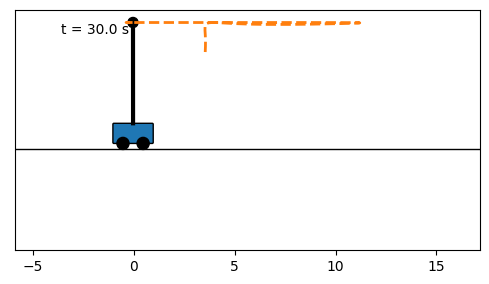

In [8]:
x = s_t[:,0]
θ = s_t[:,1]
fig, ani = animate_cartpole(t[:-1], x, θ)
ani.save('cartpole_c.mp4', writer='ffmpeg')
plt.show()

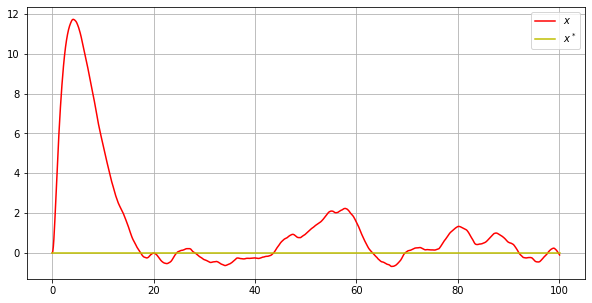

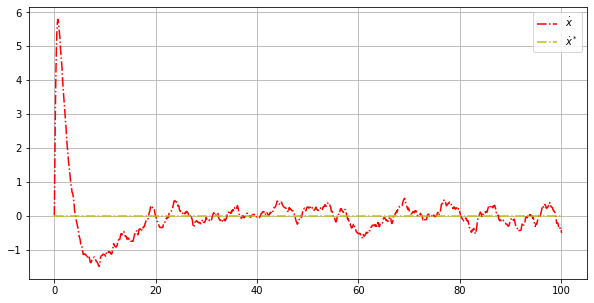

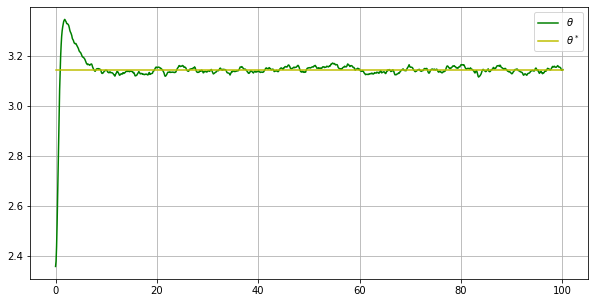

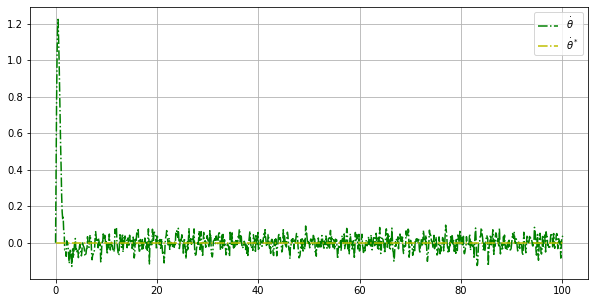

In [21]:
s_t = simulate_sys(add_noise=True, part_e = False, Q_multiply=1)

#Now plot the pos vs time
plt.figure(figsize=(10, 5))
plt.grid() #this allows us to see the grid
plt.plot(t,s_t[:,0],'r',label='$x$') 
plt.plot(t, np.zeros(t.shape), 'y', label='$x^*$')
plt.legend(fontsize=10) #show the legend

plt.show() #this says display the info here


#Now plot the pos vs time
plt.figure(figsize=(10, 5))
plt.grid() #this allows us to see the grid
plt.plot(t,s_t[:,2],'-.r',label='$\\dot{x}$')
plt.plot(t, np.zeros(t.shape), '-.y', label='$\\dot{x}^*$')
plt.legend(fontsize=10) #show the legend

plt.show() #this says display the info here


#Now plot the angle vs time
plt.figure(figsize=(10, 5))
plt.grid() #this allows us to see the grid
plt.plot(t,s_t[:,1],'g',label='$\\theta$') 
plt.plot(t,np.ones(t.shape)*np.pi,'y',label='$\\theta^*$') 
plt.legend(fontsize=10) #show the legend

plt.show() #this says display the info here


#Now plot the angle vs time
plt.figure(figsize=(10, 5))
plt.grid() #this allows us to see the grid
plt.plot(t,s_t[:,3],'-.g',label='$\\dot{\\theta}$') 
plt.plot(t,np.zeros(t.shape),'-.y',label='$\\dot{\\theta}^*$') 
plt.legend(fontsize=10) #show the legend

plt.show() #this says display the info here

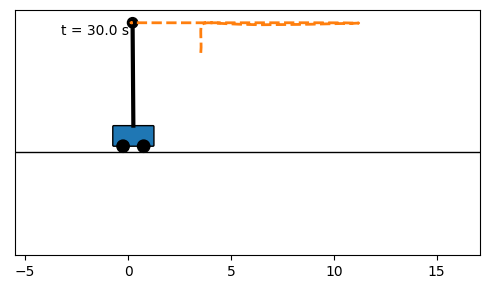

In [10]:
x = s_t[:,0]
θ = s_t[:,1]
fig, ani = animate_cartpole(t[:-1], x, θ)
ani.save('cartpole_d.mp4', writer='ffmpeg')
plt.show()

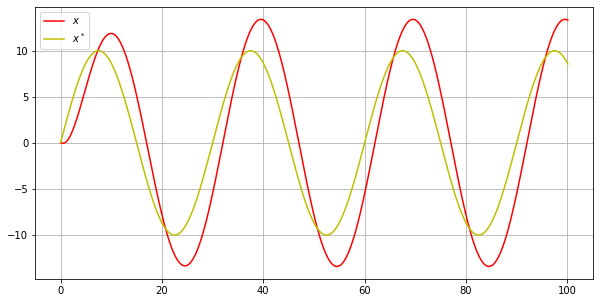

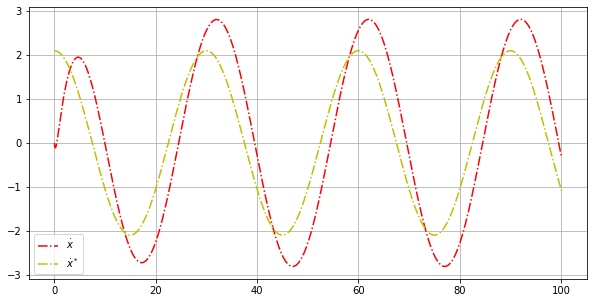

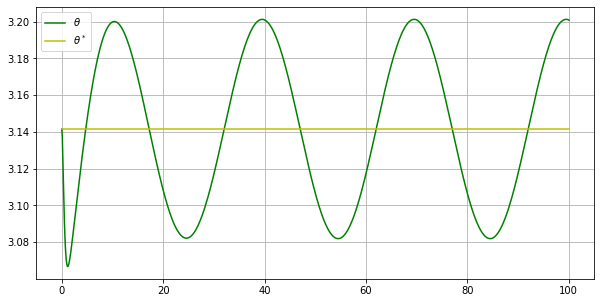

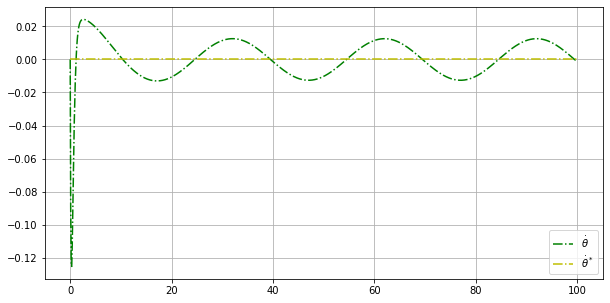

In [22]:
s_t = simulate_sys(add_noise=False, part_e = True, Q_multiply=1)

#Now plot the angle vs time
plt.figure(figsize=(10, 5))
plt.grid() #this allows us to see the grid
plt.plot(t,s_t[:,0],'r',label='$x$') 
plt.plot(t, 10*np.sin(2*np.pi*t/30), 'y', label='$x^*$')
plt.legend(fontsize=10) #show the legend

plt.show() #this says display the info here


#Now plot the angle vs time
plt.figure(figsize=(10, 5))
plt.grid() #this allows us to see the grid
plt.plot(t,s_t[:,2],'-.r',label='$\\dot{x}$')
plt.plot(t, 10*(2*np.pi/30)*np.cos(2*np.pi*t/30), '-.y', label='$\\dot{x}^*$')
plt.legend(fontsize=10) #show the legend

plt.show() #this says display the info here


#Now plot the angle vs time
plt.figure(figsize=(10, 5))
plt.grid() #this allows us to see the grid
plt.plot(t,s_t[:,1],'g',label='$\\theta$') 
plt.plot(t,np.ones(t.shape)*np.pi,'y',label='$\\theta^*$') 
plt.legend(fontsize=10) #show the legend

plt.show() #this says display the info here


#Now plot the angle vs time
plt.figure(figsize=(10, 5))
plt.grid() #this allows us to see the grid
plt.plot(t,s_t[:,3],'-.g',label='$\\dot{\\theta}$') 
plt.plot(t,np.zeros(t.shape),'-.y',label='$\\dot{\\theta}^*$') 
plt.legend(fontsize=10) #show the legend

plt.show() #this says display the info here




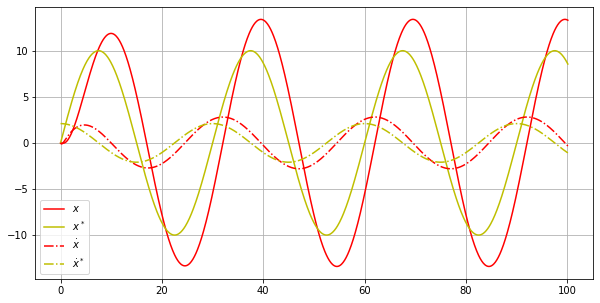

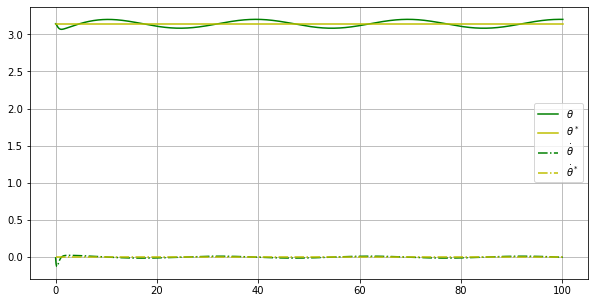

In [23]:
#Now plot the angle vs time
plt.figure(figsize=(10, 5))
plt.grid() #this allows us to see the grid
plt.plot(t,s_t[:,0],'r',label='$x$') 
plt.plot(t, 10*np.sin(2*np.pi*t/30), 'y', label='$x^*$')
plt.plot(t,s_t[:,2],'-.r',label='$\\dot{x}$')
plt.plot(t, 10*(2*np.pi/30)*np.cos(2*np.pi*t/30), '-.y', label='$\\dot{x}^*$')
plt.legend(fontsize=10) #show the legend

plt.show() #this says display the info here


#Now plot the angle vs time
plt.figure(figsize=(10, 5))
plt.grid() #this allows us to see the grid
plt.plot(t,s_t[:,1],'g',label='$\\theta$') 
plt.plot(t,np.ones(t.shape)*np.pi,'y',label='$\\theta^*$') 
plt.plot(t,s_t[:,3],'-.g',label='$\\dot{\\theta}$') 
plt.plot(t,np.zeros(t.shape),'-.y',label='$\\dot{\\theta}^*$') 
plt.legend(fontsize=10) #show the legend

plt.show() #this says display the info here

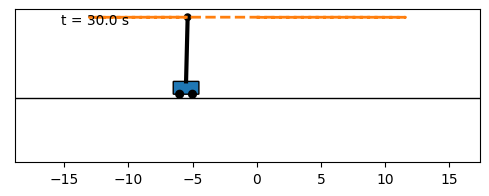

In [13]:
x = s_t[:,0]
θ = s_t[:,1]
fig, ani = animate_cartpole(t[:-1], x, θ)
ani.save('cartpole_e.mp4', writer='ffmpeg')
plt.show()

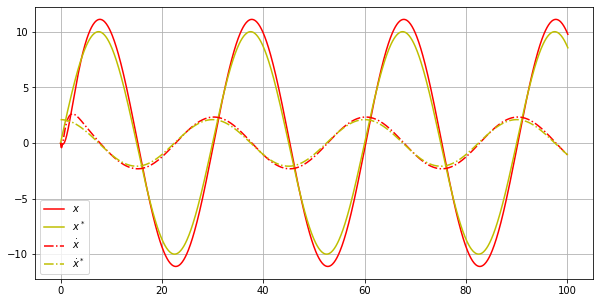

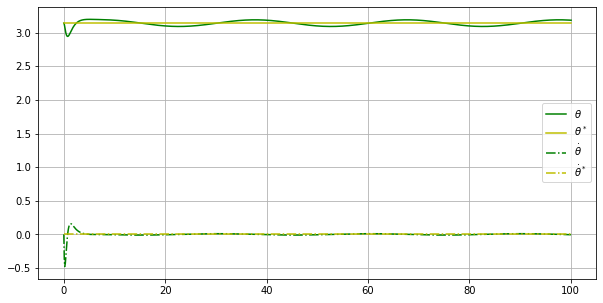

In [24]:
s_t = simulate_sys(add_noise=False, part_e = True, Q_multiply=100)

#Now plot the angle vs time
plt.figure(figsize=(10, 5))
plt.grid() #this allows us to see the grid
plt.plot(t,s_t[:,0],'r',label='$x$') 
plt.plot(t, 10*np.sin(2*np.pi*t/30), 'y', label='$x^*$')
plt.plot(t,s_t[:,2],'-.r',label='$\\dot{x}$')
plt.plot(t, 10*(2*np.pi/30)*np.cos(2*np.pi*t/30), '-.y', label='$\\dot{x}^*$')
plt.legend(fontsize=10) #show the legend

plt.show() #this says display the info here


#Now plot the angle vs time
plt.figure(figsize=(10, 5))
plt.grid() #this allows us to see the grid
plt.plot(t,s_t[:,1],'g',label='$\\theta$') 
plt.plot(t,np.ones(t.shape)*np.pi,'y',label='$\\theta^*$') 
plt.plot(t,s_t[:,3],'-.g',label='$\\dot{\\theta}$') 
plt.plot(t,np.zeros(t.shape),'-.y',label='$\\dot{\\theta}^*$') 
plt.legend(fontsize=10) #show the legend

plt.show() #this says display the info here

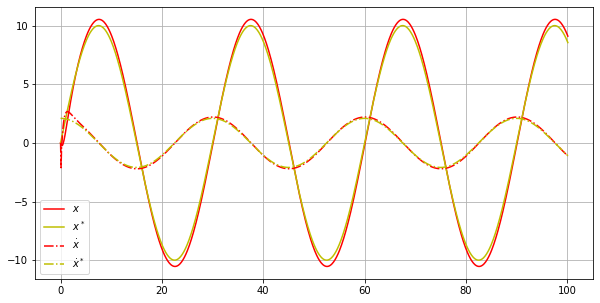

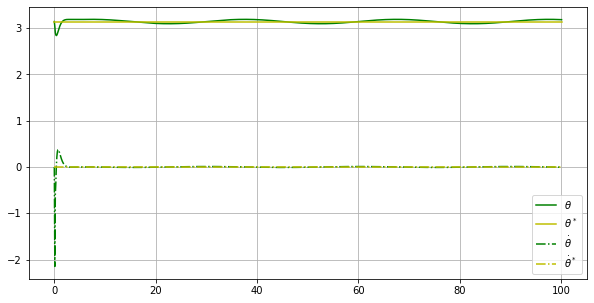

In [27]:
s_t = simulate_sys(add_noise=False, part_e = True, Q_multiply=100000)

#Now plot the angle vs time
plt.figure(figsize=(10, 5))
plt.grid() #this allows us to see the grid
plt.plot(t,s_t[:,0],'r',label='$x$') 
plt.plot(t, 10*np.sin(2*np.pi*t/30), 'y', label='$x^*$')
plt.plot(t,s_t[:,2],'-.r',label='$\\dot{x}$')
plt.plot(t, 10*(2*np.pi/30)*np.cos(2*np.pi*t/30), '-.y', label='$\\dot{x}^*$')
plt.legend(fontsize=10) #show the legend

plt.show() #this says display the info here


#Now plot the angle vs time
plt.figure(figsize=(10, 5))
plt.grid() #this allows us to see the grid
plt.plot(t,s_t[:,1],'g',label='$\\theta$') 
plt.plot(t,np.ones(t.shape)*np.pi,'y',label='$\\theta^*$') 
plt.plot(t,s_t[:,3],'-.g',label='$\\dot{\\theta}$') 
plt.plot(t,np.zeros(t.shape),'-.y',label='$\\dot{\\theta}^*$') 
plt.legend(fontsize=10) #show the legend

plt.show() #this says display the info here